## Part3 Data Analysis

### ライブラリのインポート

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

### 標準化

In [2]:
def plot_hist(list_title,values_arr,color='b'):
    ''' ヒストグラム作成用関数 '''
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 5))
    for i,ax in enumerate(axes.flat):
        if i < len(list_title):
            plt.axes(ax)
            plt.hist(values_arr[i],color=color)
            plt.title(list_title[i],fontname="MS Gothic")
    plt.tight_layout(pad=1, w_pad=1)

In [3]:
def standardization(df_analysis,list_field):
    ''' データ標準化関数、分散と歪度を調整して変換するPowerTransformerを使用。 '''
    from sklearn.preprocessing import PowerTransformer
    
    list_scaler = []
    for item in list_field[1:]:
        data = df_analysis.loc[:,item].values.reshape(-1,1)
        scaler = PowerTransformer().fit(data)
        df_analysis.loc[:,item] = scaler.transform(data)
        list_scaler.append(scaler)
    return df_analysis,list_scaler

変換前

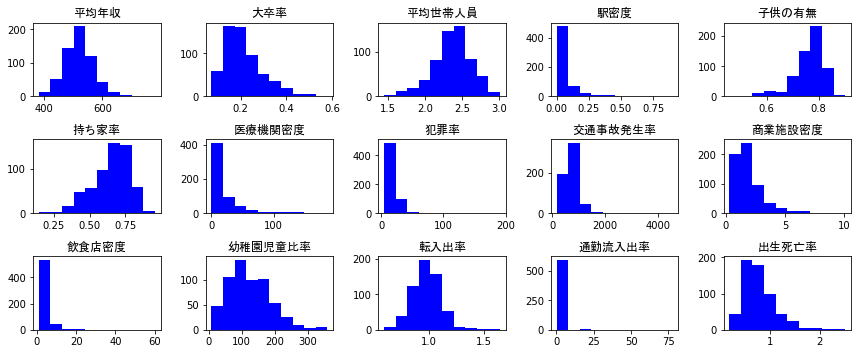

In [4]:
df_analysis = pd.read_csv('./df_preprocessed.csv')
list_field = list(df_analysis.columns)
plot_hist(list_field[1:],df_analysis.values.transpose()[1:])

変換後

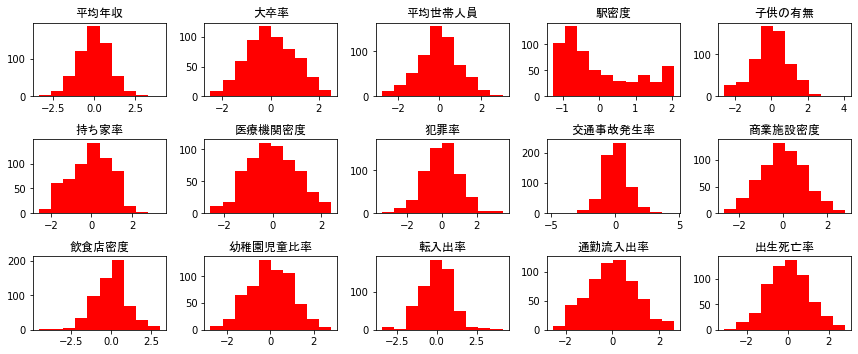

In [5]:
df_analysis,_ = standardization(df_analysis,list_field)
plot_hist(list_field[1:],df_analysis.values.transpose()[1:],color='r')

### 特徴間の相関

In [6]:
def feature_corr(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    plt.subplots(figsize=(12,8))
    plt.title('Feature Correlation')
    sns.heatmap(corr, annot=True, mask=mask, cmap="RdBu_r", fmt='.1f',
                linewidths=0.5, linecolor="k",vmin=-1,vmax=1,
                cbar_kws={'label': 'Correlation Coefficient'})
    sns.set(font="MS Gothic")
    plt.xticks(rotation=30)
    plt.show()

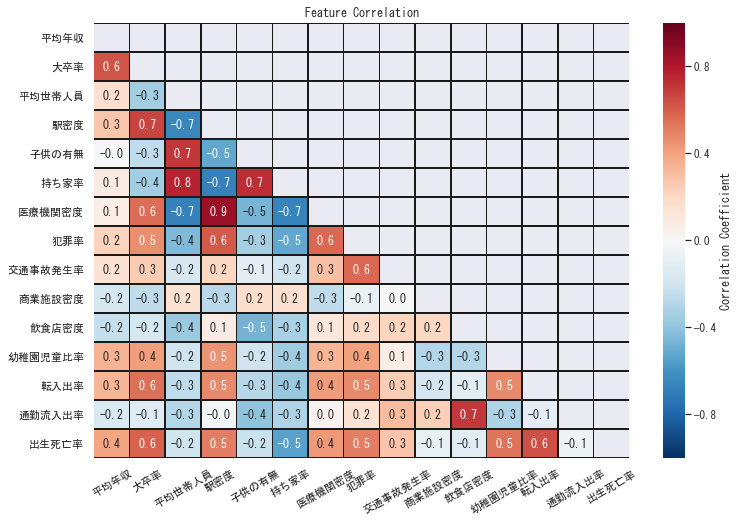

In [8]:
feature_corr(df_analysis.loc[:,list_field[1:]])

### クラスター分類

In [9]:
def df_gis_cityname(path_shapefile,df_analysis):
    ''' シェープファイルから県市区町村の情報を読み取り、コードでdf_analysisと結合する。 '''
    list_citynames = ['KEN','GUN','SEIREI','SIKUCHOSON']    
    df_gis = gpd.read_file(path_shapefile, encoding="SHIFT-JIS")
    df_gis.loc[:,list_citynames] = df_gis.loc[:,list_citynames].replace(to_replace=np.nan, value='')
    df_gis.loc[:,'CITY_JP'] = df_gis.loc[:,list_citynames].apply(lambda x: ''.join(x), axis=1)
    df_gis.set_index('JCODE',inplace=True)
    df_gis = df_gis.loc[pd.isnull(df_gis.index) == False,['CITY_JP','P_NUM']]
    df_gis = df_gis.loc[df_gis.index.drop_duplicates()]
    
    df_analysis.loc[:,'JCODE'] = df_analysis.loc[:,'JCODE'].apply(str).str.rjust(5,'0')
    df_analysis.set_index('JCODE',inplace=True)
    df_analysis = pd.concat([df_analysis,df_gis],axis=1,join='inner')
    df_analysis.reset_index(inplace=True)
    return df_analysis

In [10]:
def classification(X,num_class,df_analysis):
    ''' K平均法によるクラスター分類。 '''
    from sklearn.cluster import KMeans
    
    kmeans = KMeans(n_clusters=num_class, random_state = 42)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_
    labels = kmeans.predict(X) + 1

    df_analysis.loc[:,'Class'] = labels.astype(str)
    list_class = ['Class'+str(i+1) for i in np.arange(num_class)]
    dict_class = dict(zip(list_class,['']*len(list_class)))

    # Calculate euclidean distance from cluster centroid
    for i,centroid in enumerate(centroids):
        idx_class = df_analysis.loc[:,'Class'] == str(i+1)
        k_mean_distance = lambda x: sum(np.sqrt(np.power(x.values - centroid,2)))
        df_analysis.loc[idx_class,'km_dist'] = df_analysis.loc[idx_class,list_field[1:]].apply(k_mean_distance,axis=1)

    # 各クラスに属するDataFrameを辞書に登録。
    df_class = pd.DataFrame(columns=list_field[1:])
    for i,key in enumerate(dict_class.keys()):
        idx_tmp = df_analysis.loc[:,'Class']==str(i+1)
        df_class.loc[key,:] = df_analysis.loc[idx_tmp,list_field[1:]].apply(np.median)
        dict_class[key] = df_analysis.loc[idx_tmp,:]
    
    for item in list(df_class.columns):
        df_class.loc[:,item] = pd.to_numeric(df_class[item])

    return df_analysis,dict_class,df_class,centroids

In [11]:
path_shapefile = "./japan_ver81/japan_ver81.shp"
df_analysis = df_gis_cityname(path_shapefile,df_analysis)

In [12]:
num_class = 6
X = df_analysis.loc[:,list_field[1:]].values
df_analysis,dict_class,df_class,centroids = classification(X,num_class,df_analysis)

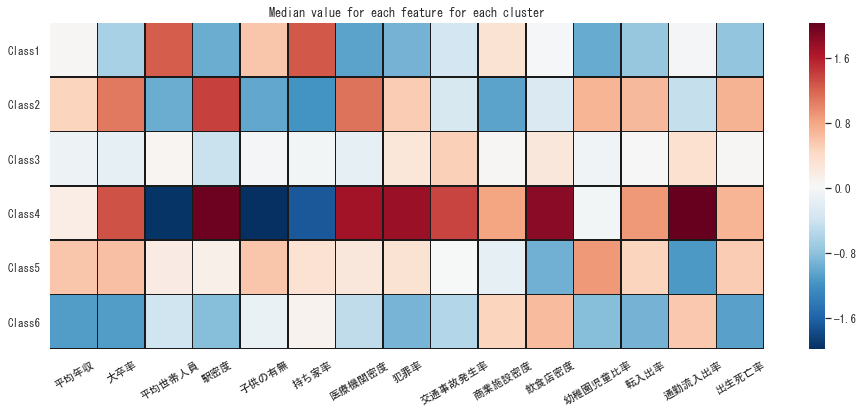

In [13]:
plt.subplots(figsize=(16,6))
sns.set(font="MS Gothic")
sns.heatmap(df_class, cmap="RdBu_r", fmt='.1f', linewidths=0.5, linecolor="k")
plt.title('Median value for each feature for each cluster',fontsize=12)
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()

### 各特徴の平均値と代表都市を見ながら、各クラスの簡単な解釈を行う

Class1: 持ち家ありの家族世帯、治安良し、車社会、人口減少

In [14]:
dict_class['Class1'].loc[:,['CITY_JP','km_dist','P_NUM']].sort_values(by='km_dist').head(5)

,CITY_JP,km_dist,P_NUM
104,栃木県鹿沼市,4.464477,99949
80,福島県須賀川市,4.480870,77990
247,新潟県新発田市,5.058640,100314
89,茨城県石岡市,5.085576,77479
286,岐阜県中津川市,5.092066,80894


Class2: 若い夫婦が多そうな郊外、高所得

In [15]:
dict_class['Class2'].loc[:,['CITY_JP','km_dist','P_NUM']].sort_values(by='km_dist').head(5)

,CITY_JP,km_dist,P_NUM
209,神奈川県横浜市鶴見区,4.761168,287620
535,福岡県福岡市早良区,4.762934,216975
401,大阪府豊中市,4.855646,403030
403,大阪府吹田市,4.942710,367068
205,東京都府中市,5.130770,256748


Class3: あまり特徴なし、中規模の地方都市

In [16]:
dict_class['Class3'].loc[:,['CITY_JP','km_dist','P_NUM']].sort_values(by='km_dist').head(5)

,CITY_JP,km_dist,P_NUM
110,群馬県高崎市,2.839150,375491
492,広島県福山市,3.166647,471974
469,鳥取県米子市,3.826830,149731
502,山口県防府市,4.159638,117713
349,三重県四日市市,4.421602,312457


<br>

Class4: 大都会

In [17]:
dict_class['Class4'].loc[:,['CITY_JP','km_dist','P_NUM']].sort_values(by='km_dist').head(5)

,CITY_JP,km_dist,P_NUM
0,北海道札幌市中央区,4.768521,230382
388,大阪府大阪市天王寺区,4.789108,73610
306,愛知県名古屋市東区,4.861181,75080
368,京都府京都市下京区,4.929431,77194
182,東京都新宿区,5.087953,334193


Class5: ベッドタウン

In [18]:
dict_class['Class5'].loc[:,['CITY_JP','km_dist','P_NUM']].sort_values(by='km_dist').head(5)

,CITY_JP,km_dist,P_NUM
146,埼玉県新座市,3.432628,164028
147,埼玉県桶川市,3.988154,75071
139,埼玉県上尾市,4.353179,227890
141,埼玉県越谷市,4.743954,336565
341,愛知県尾張旭市,5.085856,82605


Class6: 過疎化が進んでいる中規模の地方都市

In [19]:
dict_class['Class6'].loc[:,['CITY_JP','km_dist','P_NUM']].sort_values(by='km_dist').head(5)

,CITY_JP,km_dist,P_NUM
35,青森県青森市,3.885309,293066
36,青森県弘前市,4.867607,177189
573,大分県日田市,5.035939,68429
520,愛媛県大洲市,5.139220,45539
499,山口県下関市,5.269986,272360


###  クラスターの視覚化のため主成分分析で次元削減

In [20]:
def ScreePlot(EigenValue,ax_left,prmax,ls=None,mkr=None):
    ''' Scree plot to see the contribution of each principal component '''
    # Individual    
    x = np.arange(len(EigenValue)) + 1
    ax_left.plot(x, EigenValue*100,'b',linestyle=ls,marker=mkr,label='Eigen Value')
    ax_left.set_ylim([prmax['ymin1']-1,prmax['ymax1']+1])
    ax_left.set_xticks(np.arange(prmax['xmin'],prmax['xmax'] + 1e-6,prmax['xmajor']))
    ax_left.set_yticks(np.arange(prmax['ymin1'],prmax['ymax1'] + 1e-6,prmax['ymajor1']))    
    plt.grid(b=True, which='major',color='black',linestyle='-',linewidth=0.4,zorder=-2)
    plt.ylabel('Eigen Value [%]')
    plt.xlabel('Number of components')

    # Cumulative
    ratio_lr = (prmax['ymax2'] - prmax['ymin2'])/(prmax['ymax1'] - prmax['ymin1'])
    x_margin = prmax['xmajor']/10    
    ax_right = ax_left.twinx()
    ax_right.plot(x, np.cumsum(EigenValue)*100,'r',linestyle=ls,marker=mkr,label='Cumulative')
    ax_right.set_xlim([prmax['xmin']-x_margin,prmax['xmax']+x_margin])
    ax_right.set_ylim([prmax['ymin2']-ratio_lr,prmax['ymax2']+ratio_lr])
    ax_right.set_yticks(np.arange(prmax['ymin2'],prmax['ymax2'] + 1e-6,prmax['ymajor2']))    
    plt.ylabel('Cumulative Eigen Value [%]')
    plt.title('Scree Plot')
    lns = ax_left.get_lines() + ax_right.get_lines()
    labs = [l.get_label() for l in lns]
    plt.legend(lns,labs,loc='center right')
    plt.tight_layout(pad=1, w_pad=1.5)

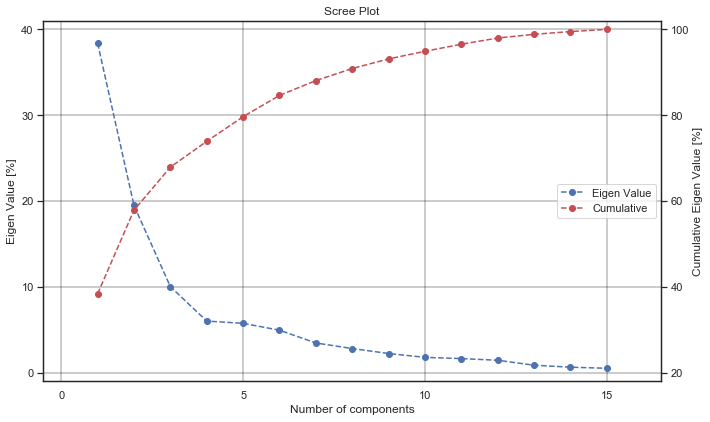

In [21]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)
pc = pca.transform(X)
pc_cent = pca.transform(centroids)
comp = pca.components_
EigenValue = pca.explained_variance_ratio_

# Visualize Principal Components for each year and Scree plot
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,6))
prmax = {'xmin':0, 'xmax':len(list_field), 'xmajor':5,
         'ymin1':0,'ymax1':40, 'ymajor1':10,
         'ymin2':20,'ymax2':100,'ymajor2':20}
ScreePlot(EigenValue,ax,prmax,ls='--',mkr='o')
plt.show()

In [22]:
def pc_mat_importance(comp,pca,xtick_label):
    ''' Visualize Principal Component-Feature Matrix by Heatmap '''
    # Sort by Eigen value of Prinicpal Component Analysis
    eigenvalues = pca.explained_variance_
    importance = eigenvalues/sum(eigenvalues)

    # Display Heat map
    fig, ax = plt.subplots(figsize=(14,6))
    ax = sns.heatmap(comp,cmap='coolwarm', linewidths=0.5, linecolor="k",
                     vmin=-1, vmax=1, cbar_kws={'label': 'Principal axes in feature space'})
    imp_pc_zip = sorted(zip(importance, np.arange(1,pca.n_components_+ 1, 1)), reverse=True)    
    idx_pc = ['PC'+str(i)+': '+'{:.1f}'.format(imp*100)+'%' for imp, i in imp_pc_zip]
    ax.set_yticklabels(idx_pc, rotation=0)
    ax.set_xticklabels(xtick_label,rotation=30, fontname="MS Gothic")
    plt.ylabel('Feature Importance sorted by PCA', fontsize=12)
    plt.show()

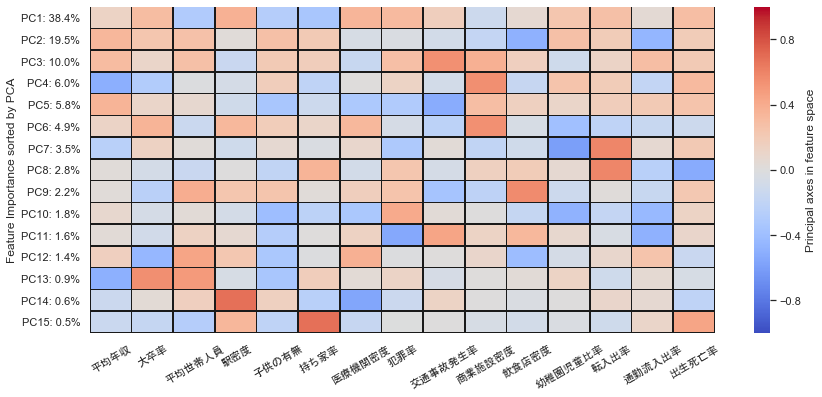

In [23]:
pc_mat_importance(comp,pca,list_field[1:])

In [24]:
def plot_pc(df_analysis,pc,pc_cent,clr_list):
    from mpl_toolkits import mplot3d
    from mpl_toolkits.mplot3d import axes3d
    
    %matplotlib notebook
    
    num_class = len(clr_list)
    fig = plt.figure(figsize=(8,6))
    ax = plt.axes(projection='3d')
    for i in np.arange(num_class):
        idx = df_analysis.Class == str(i+1)
        ax.scatter3D(pc[idx,0], pc[idx,1], pc[idx,2], s=10, c=clr_list[i],label='Class' + str(i+1))

    # Plot Centroids
    for i in np.arange(num_class):
        ax.scatter3D(pc_cent[i,0], pc_cent[i,1], pc_cent[i,2], s=100, c=clr_list[i], marker='*',
                     label= 'Class' + str(i+1) + ' (Centroid)', edgecolors='black',linewidths=0.5)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


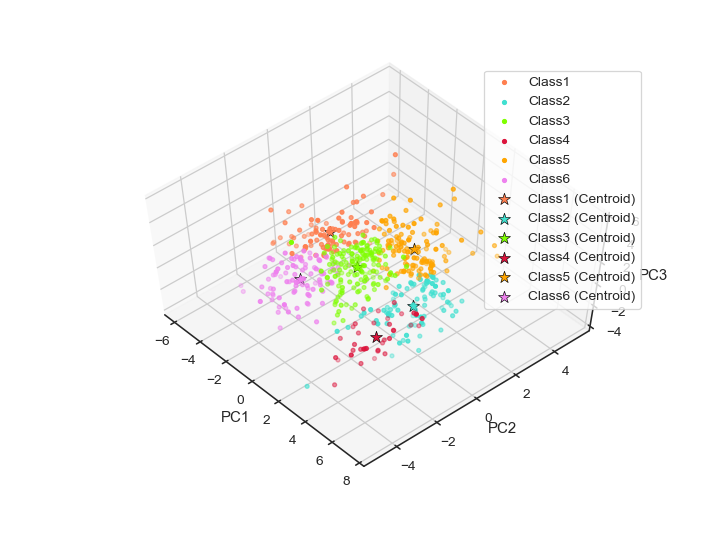

In [25]:
clr_list=['coral','turquoise','chartreuse','crimson','orange','violet']
plot_pc(df_analysis,pc,pc_cent,clr_list)

In [26]:
df_analysis.to_csv('./df_analysis.csv',index=False)